In [199]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
import pickle 
from rdkit import Chem
from rdkit.Chem import MACCSkeys

## Load data

In [200]:
df = pd.read_csv('irritation.csv')
df.head()

,SMILES,Class
0,CC#CC,1
1,CCC=C,1
2,O=CC=O,1
3,CCC=O,1
4,FCC#N,1


### Converting to MACCS fp

In [201]:
smiles = df['SMILES'].to_list()

In [202]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df2 = pd.DataFrame(MACCS_list,columns=header)
df2.insert(loc=0, column='smiles', value=smiles)
df2.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,CC#CC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CCC=C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,O=CC=O,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


### Split data into predictor and target

In [203]:
X = df2.iloc[:, 1:168].astype(int)
y = np.array(df[['Class']]).ravel()

In [204]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)

In [205]:
clf = GradientBoostingClassifier(random_state=10)
clf.fit(Xtrain, ytrain)

GradientBoostingClassifier(random_state=10)

In [206]:
clf.score(Xtest, ytest)

0.9339080459770115

In [37]:
ypred = clf.predict(Xtest)

In [38]:
f1 = f1_score(ytest, ypred)
print(f1)

0.9559668155711551


### Hyperparameter optimization

In [210]:
from sklearn.model_selection import GridSearchCV

In [211]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.2],
    "min_samples_leaf": [1, 5, 10],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 1.0],
    }

In [212]:
opt_clf = GridSearchCV(GradientBoostingClassifier(random_state=10), parameters, cv=10, n_jobs=-1)

In [213]:
opt_clf.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'subsample': [0.5, 1.0]})

In [214]:
opt_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'subsample': 0.5}

In [215]:
opt_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=8, max_features='sqrt', min_samples_leaf=10, subsample=0.5, random_state=10).fit(Xtrain, ytrain)

In [216]:
opt_model.score(Xtest, ytest)

0.9473180076628352

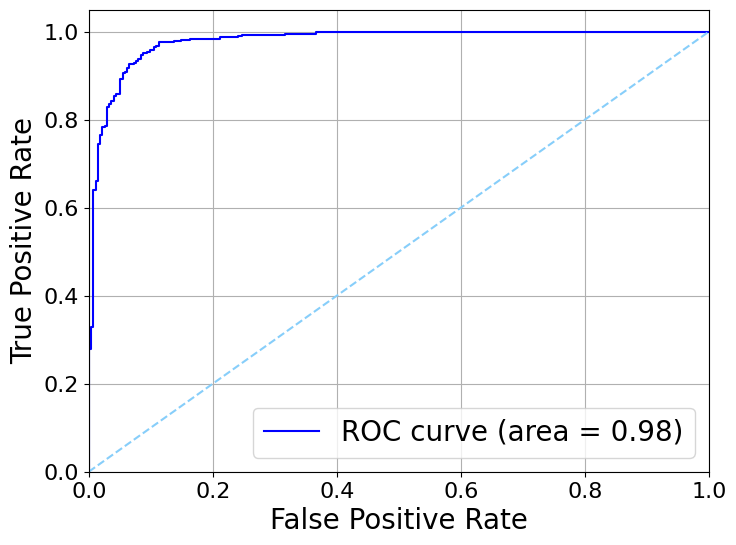

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split



# Predict probabilities for the test set
y_pred = opt_model.predict_proba(Xtest)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='#87CEFA', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc='lower right', fontsize = 20)

# Set larger font size for tick labels
plt.tick_params(axis='both', labelsize=16)

plt.grid()
plt.savefig('irr_ML.svg', dpi=700, bbox_inches='tight')
plt.show()

In [12]:
importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': df.iloc[0:5220, 0:43].columns, 'Importance': importance})

feature_importance_df

,Feature,Importance
0,exactmw,0.000619
1,amw,0.001046
2,lipinskiHBA,0.004678
3,lipinskiHBD,0.005003
4,NumRotatableBonds,0.006219
5,NumHBD,0.006857
6,NumHBA,0.004270
7,NumHeavyAtoms,0.157011
8,NumAtoms,0.001638
9,NumHeteroatoms,0.015043


In [13]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.03]

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_24848\3189182547.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')


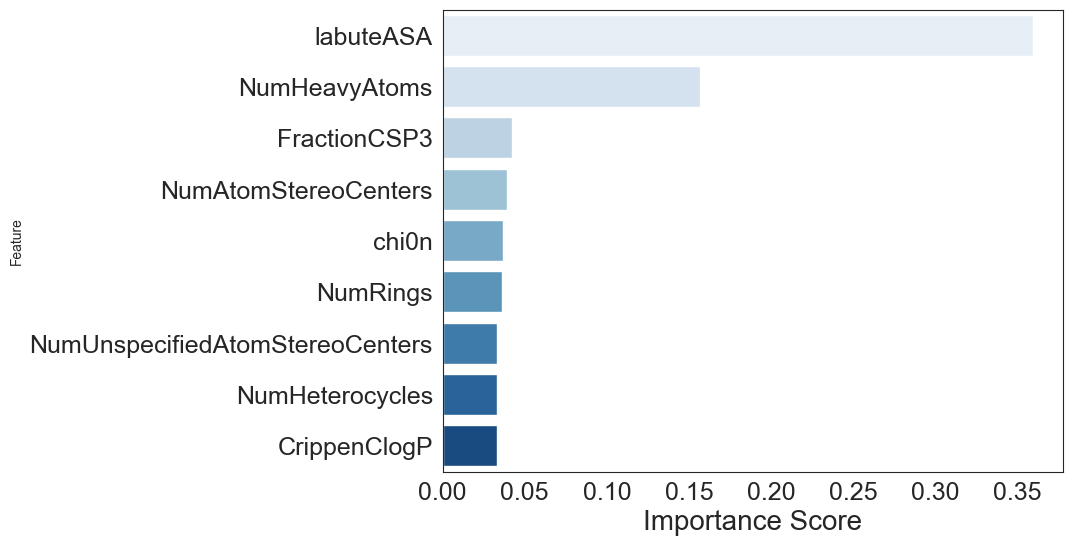

In [22]:
import matplotlib.pyplot as pyplot
import seaborn as sns
# Plot the feature importances
sns.set_style("white")

pyplot.figure(figsize=(8, 6))


sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')
sns.set_style("whitegrid")
pyplot.xlabel('Importance Score', fontsize = 20)

# Increase font size for tick labels
plt.tick_params(axis='both', labelsize=18)
pyplot.savefig('FI_irr.svg', dpi=700)
pyplot.show()

In [17]:
f1 = [0.923117616468313, 0.9502551020408163, 0.9502551020408163, 0.9502551020408163, 0.9502551020408163]
mean_f1 = np.mean(f1)
mean_f1

0.9448276049263156

In [18]:
std_f1 = np.std(f1)
std_f1

0.010854994229001312

In [16]:
acc = [0.9547413793103449, 0.9547413793103449, 0.9547413793103449, 0.9547413793103449, 0.9547413793103449]
mean_acc = np.mean(acc)
mean_acc

0.9547413793103449

In [17]:
std_acc = np.std(acc)
std_acc

0.0

## Case study

### Load generated SMILES

In [274]:
smiles = pd.read_csv('smiles_ML_1000.csv')['Smiles'].to_list()

### Convert SMILES to MACCS keys

In [275]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df3 = pd.DataFrame(MACCS_list,columns=header)
df3.insert(loc=0, column='smiles', value=smiles)
df3.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,O=CC(C(=O)O)c1cccc(Oc2ccoc2)c1C(F)(F)F,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,1,1,0
1,CC1C(OC=O)CCCC1c1cccc(C(C(=O)O)C(=O)C(=O)Cc2cc...,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
2,CC(C)(N)c1cc(Sc2ccno2)cc(N[SH](=O)=O)c1CC(=O)O,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [276]:
X = np.array(df3.iloc[:, 1:168])

### Calculate probability of being toxic for all generated molecules

In [277]:
irritation = opt_model.predict_proba(X)[:, 0]
irritation

c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([0.58073923, 0.5073253 , 0.97305476, ..., 0.03437988, 0.96707555,
       0.23243559])

In [278]:
irritation_mean = np.mean(irritation)
irritation_mean

0.3401025496639467

### Calculating average probability of being toxic for molecules generated by FREED++

In [252]:
irr_noML = [0.3454665292370736, 0.4561733350487772, 0.5260598172171741, 0.47764457384484577, 0.41149758813266785]
irr_noML_mean = np.mean(irr_noML)
irr_noML_mean

0.44336836869610774

In [282]:
std_noML = np.std(irr_noML)
std_noML

0.0612816740704576

### Calculating average probability of being toxic for molecules generated by our pipeline

In [279]:
irr_ML = [0.42277860811469575, 0.46307397340156947, 0.5303684548384139, 0.4368626118632615, 0.3401025496639467]
irr_ML_mean = np.mean(irr_ML)
irr_ML_mean

0.43863723957637746

In [283]:
std_ML = np.std(irr_ML)
std_ML

0.06160438365082444

### Save model

In [197]:
pkl_filename = "pickle_model_irritation.pkl"

In [198]:
with open(pkl_filename, 'wb') as file: 
    pickle.dump(opt_model, file)